<a href="https://colab.research.google.com/github/leabizbille/ProjetIOT/blob/main/Home.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
!pip install summarytools -q

In [10]:
!pip install pygwalker -q

In [11]:
pip install sweetviz -q

In [12]:
import pygwalker as pyg
from summarytools import dfSummary # module pandas-profiling
import pandas as pd
import sweetviz as sv
import missingno as msno

In [73]:
# Charger le fichier CSV en conservant les titres des colonnes
val_roland = pd.read_csv("/content/Val de Roland_2024.csv",sep= ";", parse_dates=[0], dayfirst=True)
THabitat2023 = pd.read_csv("/content/Tours Habitat_2023.csv",sep= ";", parse_dates=[0], dayfirst=True)
THabitat2024= pd.read_csv("/content/Tours Habitat_2024.csv",sep= ";", parse_dates=[0], dayfirst=True)

<Axes: >

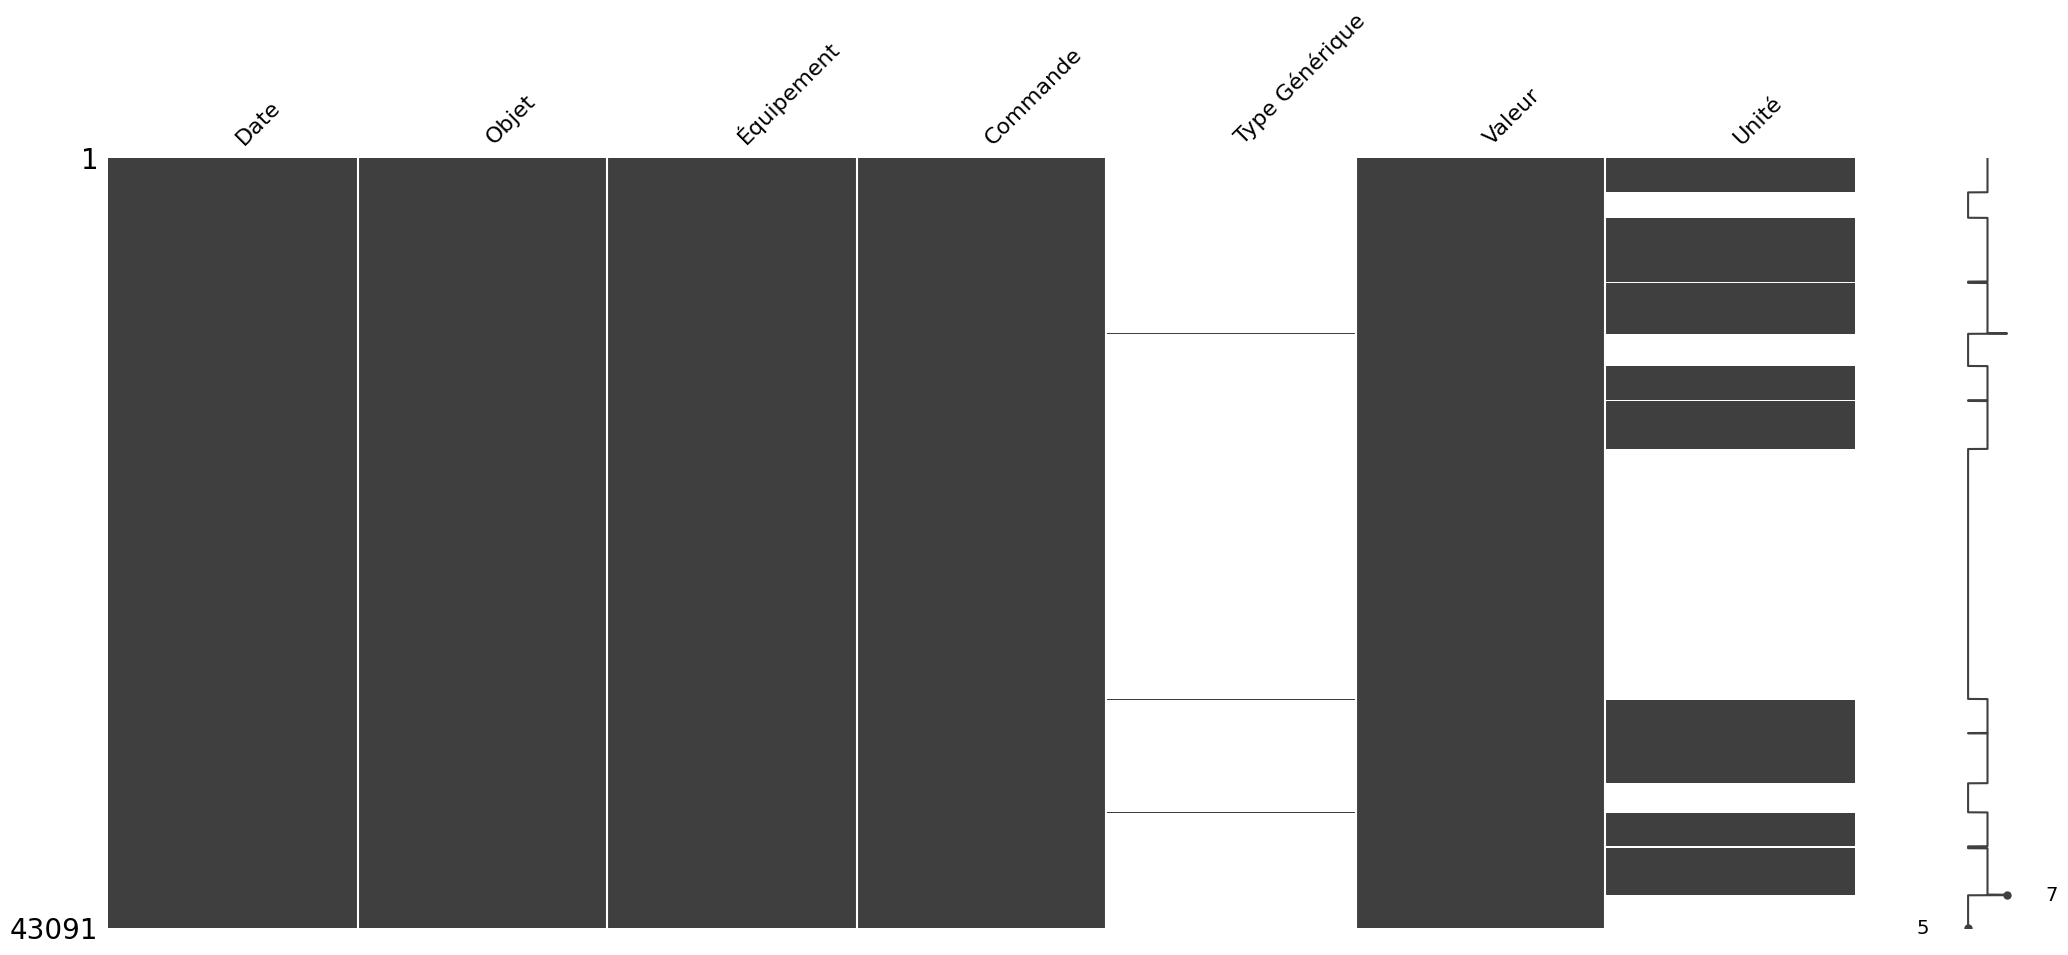

In [74]:
msno.matrix(val_roland)

In [96]:
# Description pour comprendre les données et mettre en suite le tableau en forme
dfSummary(val_roland)

No,Variable,Stats / Values,Freqs / (% of Valid),Graph,Missing
1,Équipement[object],1. Conso_Total_index2. Thermostat3. Conso_horaire4. 4PM5. Occupation_Hier6. Occupation_Aujourdhui,"19,261 (44.7%)10,942 (25.4%)7,486 (17.4%)5,206 (12.1%)109 (0.3%)87 (0.2%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAACKCAYAAAC96ziyAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjguMCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy81sbWrAAAACXBIWXMAAA9hAAAPYQGoP6dpAAAChklEQVR4nO3bQWrbUABF0a9g0nZiEwJZQruHLKKL7SK8iO4hhGjQpJm4g0JHbTKocyWUc1bwMZcvZPSm0+k0oHCx9AF4P8RGRmxkxEZmGmN8GmNcLn2QlXk+nU6PSx9ia3bX19df9/v91dIHWZN5nu+nafomuPPa7ff7q9vb28fD4fC09GHW4OHh4ePxeLy6u7u7HGOI7Yx2Y4xxOByebm5ufix9mBX5tPQBtsgLAhmxkREbGbGRERsZsZERGxmxkREbGbGRERsZsZERG5ndGL8/q1n6IGvht3g7u3me74/H49XwWc0f8zzfjzGelz7H1vgs/O98Fv4GJiNlKmu/2dwwG7LqwYvhybasdvBieLI9ax+8eEPeEH/qkhEbGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbmdWuq9Z4Jv7PqtdVVk7bYoNAxrqKTH2zuanesXRdZS31vmXrKmsp6nXV6t546fhTl4zYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyGTrKmsp0nWVtdT7ZoNAxrqKzLlvNjcX/3TWdZX1FC8527rKeorXnHtdZT3FP/lTl4zYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjczZBi8GLbzmrIMXgxZe4rNwMgYvZLwgkBEbmYtpmr5M0+RNkjd3Mcb4PMb4sPRB2D6PUTJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MhdjjO9jjJ9LH4TtM3gh4zFKRmxkDF7IGLyQ8RglIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjLWVWSsq8h4jJIRGxmxkREbmV956uN3Qz7biQAAAABJRU5ErkJggg=="">",0(0.0%)
2,Commande[object],1. TIC_enedis2. TemperatureReelle3. Conso_Total_kw/h4. Chauffage_Conso5. Chauffage_Conso_Total6. Chauffage_OnOff7. Presence_absence8. Ballon_OnOff9. TV-Frigo_OnOff10. TemperatureDesiree,"19,261 (44.7%)10,872 (25.2%)7,486 (17.4%)1,936 (4.5%)1,629 (3.8%)1,427 (3.3%)196 (0.5%)116 (0.3%)98 (0.2%)70 (0.2%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAADnCAYAAAAJgSQ2AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjguMCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy81sbWrAAAACXBIWXMAAA9hAAAPYQGoP6dpAAAD00lEQVR4nO3dwW3bZgCG4Z+GkDYXCYYAj9Du4CEybIfQEN3BMKxDk+aiHpL2Ess5lHxJyM8zwQ/jBWkS/OzpcrkMKNytfQDeD7GRERsZsZERGxmxkREbGbGRERuZaYzxcYzxYe2DbMzXy+Xyee1D3Jrd8Xj8tN/v79c+yJacz+fnaZr+ENy8dvv9/v7x8fHz4XD4svZhtuDl5eXX0+l0//T09GGMIbYZ7cYY43A4fHl4ePhr7cNsyMe1D3CLPCCQERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGR2Y3x7bOatQ+yFX4Wy9mdz+fn0+l0P3xW85/z+fw8xvi69jlujc/CX+ez8AVM/ooRla1f2VxhbsimBy+GJ7dls4MXw5Pbs/XBiyfkG+KlLhmxkREbGbGRERsZsZERGxmxkREbGbGRERsZsZERG5nNDl62eCb+n00PXgxPbovPwskYvJCpr2yuVO9YOngxYHnfssGLAQv14GVzT7x0vNQlIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYy2brKWop0XWUt9b7ZIJCxriLzsyubKxGzeXNdZQ3FnK6uq6yhmNvP1lXWUMzGS10yYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyVwcvBirM7c3Bi4EKc/JZOBmDFzJvXdlc1ZjV1cGLsQtze3XwYuzCEt4avBi7MCsvdcmIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2Mi8OngxdmEJVwcvxi7MzWfhZAxeyHhAIHPtNuoWyuxeXVdZVrGEH9ZVllUs5dq6yrKK2XlAICM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiI/PDusqyiqW8uq6yrGIJPgsnY11F5t8r23AlY2m74/H4aYwxDFxY2t1+v7//vq669m8gYRbes5ERGxmxkREbGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxkdl9H7eMYeDCwnwWTsbghYzf2ciIjczdNE2/T9PkTy6wuLsxxm9jjF/WPgi3z22UjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI3M3RjjzzHG32sfhNtn8ELGbZSM2MgYvJAxeCHjNkpGbGTERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERsbghYzBCxm3UTJiI2PwQsbghYzbKBmxkREbGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRsa4iY11Fxm2UjNjIiI2M2MiIjYzYyIiNjNjI/ANCMmlWN6g2QAAAAABJRU5ErkJggg=="">",0(0.0%)
3,Type Générique[object],1. nan2. ALARM_STATE3. THERMOSTAT_SETPOINT,"42,868 (99.5%)153 (0.4%)70 (0.2%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAABFCAYAAABdVZTTAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjguMCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy81sbWrAAAACXBIWXMAAA9hAAAPYQGoP6dpAAABeklEQVR4nO3csW3bUBiF0f8RRBw3JAQCGsHZQUO49Z4ZQkNkCUEsYlsNXdgeQfcB9DmVylt8EEmBT23btoKEofcAfo5WVY9V9av3EHbvNi7L8jxN06H3EvZtXdfLOE3T4XQ6vc7z/NZ7EPt0vV5/n8/nw1hVNc/z2/F4/N97FLv26AGBGLERIzZixEaM2IgRGzFiI0ZsxIiNGLERIzZixEaM2IgRGzFj1ef7Rr2HsF/ffbVlWV68qcu9ret6cQaBlFtzlI+U72+22rbttfMWdm5cluW5qqq19ldw3NMwTdPh6wHBfRt35Xc2YsRGjNiIERsxYiNGbMSIjRixESM2YsRGjNiIERsxYiNGbMSIjRixETOu63r5+nzruoTdcwaBGKeriHHPRozYiBlaa39aa/7rg7sbquqpqh56D2H/XEaJERsxYiNGbMSIjRixESM

- 49 % de nan dans les Unités -> regarder pour faire des modifications
- 99.5 % de donnée manquante dans "Type Générique". Chercher l'utilisation et analyse l'interet.
- Le logement 2 à 43% des données. Soit 3 x plus que le logement 3 et 4, chacun.

Pour toutes les colonnes, reformater les données.
Un pivotement ou une transposition du tableau sera probablement nécessaire.

Mélange des modalites entre appartement et type d équipement

In [76]:
# Séparer la colonne 'datetime' en deux colonnes distinctes
val_roland[['date', 'time']] = val_roland['Date'].str.split(' ', expand=True)

# Convertir les nouvelles colonnes au format datetime
val_roland['date'] = pd.to_datetime(val_roland['date'], format='%Y-%m-%d')
val_roland['time'] = pd.to_datetime(val_roland['time'], format='%H:%M:%S').dt.time

# Supprimer l'ancienne colonne si elle n'est plus nécessaire
val_roland= val_roland.drop(columns=['Date'])

In [77]:
# Extraction des informations dans de nouvelles colonnes
val_roland['Logement'] = val_roland['Objet'].str.extract(r'(LOGEMENT\d+)')
val_roland['Replicat'] = val_roland['Objet'].str.extract(r'-\s([AB])')
val_roland['Pilote'] = val_roland['Objet'].str.contains(r'\(piloté\)').map({True: 'piloté', False: 'non piloté'})

# Supprimer l'ancienne colonne
val_roland= val_roland.drop(columns=['Objet'])

In [78]:
# Trouver toutes les modalités uniques dans la colonne 'Équipement'
modalites = val_roland['Équipement'].unique()

# Afficher les modalités
print(modalites)

['B001 - arrivée du jour' 'B001 - Conso' 'B001 - occupation'
 'LOGEMENT01_4PM' 'LOGEMENT01_TEMP' 'Thermostat Logement 1' 'WIFITIC001'
 'B002 - arrivée du jour' 'B002 - Conso' 'B002 - occupation'
 'LOGEMENT02_4PM' 'LOGEMENT02_TEMP' 'WIFITIC002' 'A301 - arrivée du jour'
 'A301 - Conso ' 'A301 - occupation' 'LOGEMENTS03_TEMP' 'WIFITIC003'
 'A302 - arrivée du jour' 'A302 - Conso' 'A302 - occupation'
 'LOGEMENT04_4PM' 'LOGEMENT04_TEMP' 'Thermostat Logement 4' 'WIFITIC004']


In [79]:
# Remplacer les valeurs avec "_" par ce qui se trouve après, sinon garder la valeur intacte
val_roland['Équipement'] = val_roland['Équipement'].str.split('_').str[1].fillna(val_roland['Équipement'])
val_roland['Équipement'] = val_roland['Équipement'].str.split(' - ').str[1].fillna(val_roland['Équipement'])


In [80]:
# Fonction de nettoyage
def nettoyer_equipement(data):
    data = data.strip()  # Supprime les espaces au début et à la fin
    if data.startswith('WIFITIC'):  # Vérifie si le texte commence par "WIFITIC"
        return 'Conso_Total_index'
    if data.startswith('Thermostat'):
        return 'Thermostat'
    if data.startswith('TEMP'): # Changement de nom et clarifie
        return 'Thermostat'
    elif data == 'Conso ':  # Nettoie "Conso " avec un espace
        return 'Conso'
    elif data == 'Conso': # Changement de nom
        return 'Conso_horaire'
    elif data == 'occupation':  # Clarifie
        return 'Occupation_Aujourdhui'
    elif data == 'arrivée du jour':  # Clarifie
        return 'Occupation_Hier'
    else:
        return data  # Conserve les autres modalités intactes

# Appliquer la fonction de nettoyage à la colonne Equipement
val_roland['Équipement'] = val_roland['Équipement'].apply(nettoyer_equipement)

In [81]:
# Trouver toutes les modalités uniques dans la colonne 'Équipement'
modalites = val_roland['Équipement'].unique()

# Afficher les modalités
print(modalites)

['Occupation_Hier' 'Conso_horaire' 'Occupation_Aujourdhui' '4PM'
 'Thermostat' 'Conso_Total_index']


* Attention au 4 PM qui correspond à beaucoup de chose !

In [82]:
# Trouver toutes les modalités uniques dans la colonne 'Équipement'
modalites = val_roland['Commande'].unique()

# Afficher les modalités
print(modalites)

['Etat arrivée du jour' 'Conso_Heure_B001' 'Etat occupation'
 '0 - CHAUFFAGE Etat ' '0 - CHAUFFAGE instantané' '0 - CHAUFFAGE total'
 '1 - ECS Etat ' '2 - Prise Etat ' 'Température' 'Consigne' 'index'
 'Conso_Heure_B002' 'Sw 1 Etat ' 'Sw 2 Etat ' 'Conso_Heure_A301'
 'Conso_Heure_A302']


In [98]:
# Fonction de nettoyage
def nettoyer_commande(data):
    data = data.strip()  # Supprime les espaces au début et à la fin
    if data.startswith('Conso_Heure'):  # Vérifie si le texte commence par Conso_Heure
        return 'Conso_Total_kw/h'
    if data.startswith('0 - CHAUFFAGE Etat'):
        return 'Chauffage_OnOff'
    if data.startswith('0 - CHAUFFAGE instantané'): # Changement de nom et clarifie
        return 'Chauffage_Conso'
    elif data == '0 - CHAUFFAGE total':  # Nettoie "Conso " avec un espace
        return 'Chauffage_Conso_Total'
    elif data == '1 - ECS Etat': # Changement de nom
        return 'Ballon_OnOff'
    elif data == '2 - Prise Etat': # Changement de nom
        return 'TV-Frigo_OnOff'
    elif data == 'Consigne': # Changement de nom
        return 'TemperatureDesiree'
    elif data == 'Température': # Changement de nom
        return 'TemperatureReelle'
    elif data == 'index': # Changement de nom
        return 'TIC_enedis'
    elif data == 'Température': # Changement de nom
        return 'TemperatureReelle'
    elif data == 'Sw 1 Etat': # Changement de nom
        return 'Ballon_OnOff'
    elif data == 'Sw 2 Etat': # Changement de nom
        return 'TV-Frigo_OnOff'
    elif data == 'Etat occupation':  # Clarifie
        return 'Presence_absence'
    elif data == 'Etat arrivée du jour':  # Clarifie
        return 'Presence_absence'
    else:
        return data  # Conserve les autres modalités intactes

# Appliquer la fonction de nettoyage à la colonne Equipement
val_roland['Commande'] = val_roland['Commande'].apply(nettoyer_commande)

In [84]:
# Trouver toutes les modalités uniques dans la colonne 'Équipement'
modalites = val_roland['Commande'].unique()

# Afficher les modalités
print(modalites)

['Presence_absence' 'Conso_Total_kw/h' 'Chauffage_OnOff' 'Chauffage_Conso'
 'Chauffage_Conso_Total' 'Ballon_OnOff' 'TV-Frigo_OnOff'
 'TemperatureReelle' 'TemperatureDesiree' 'TIC_enedis']


Mettre "Index" comme unité, si TIC enedis dans la colonne commande.

In [92]:
# Mettre "index" dans la colonne 'Unité' si "index" est dans la colonne 'Commande', sinon garder la valeur existante
val_roland['Unité'] = val_roland.apply(lambda row: 'Oui-Non' if 'Presence_absence' in row['Commande'] and pd.isna(row['Unité']) else row['Unité'], axis=1)

Mettre "ON-Off" comme unité, si la ligne correspond à un object Allumé ou éteint.

In [86]:
# Mettre "On-Off" dans la colonne 'Unité' si " ... " est dans la colonne 'Commande', sinon garder la valeur existante
val_roland['Unité'] = val_roland.apply(lambda row: 'On-Off' if 'Chauffage_OnOff' in row['Commande'] and pd.isna(row['Unité']) else row['Unité'], axis=1)
val_roland['Unité'] = val_roland.apply(lambda row: 'On-Off' if 'Ballon_OnOff' in row['Commande'] and pd.isna(row['Unité']) else row['Unité'], axis=1)
val_roland['Unité'] = val_roland.apply(lambda row: 'On-Off' if 'TV-Frigo_OnOff' in row['Commande'] and pd.isna(row['Unité']) else row['Unité'], axis=1)

In [ ]:
# Mettre "Oui-Non" dans la colonne 'Unité' si "Presence humaine" est dans la colonne 'Commande', sinon garder la valeur existante
val_roland['Unité'] = val_roland.apply(lambda row: 'On-Off' if 'Chauffage_OnOff' in row['Commande'] and pd.isna(row['Unité']) else row['Unité'], axis=1)

Verification du nombre de valeur NA

In [106]:
print(val_roland.isna().sum())

Équipement            0
Commande              0
Type Générique    42868
Valeur                0
Unité                 0
date                  0
time                  0
Logement              0
Lettre                0
Pilote                0
dtype: int64


<Axes: >

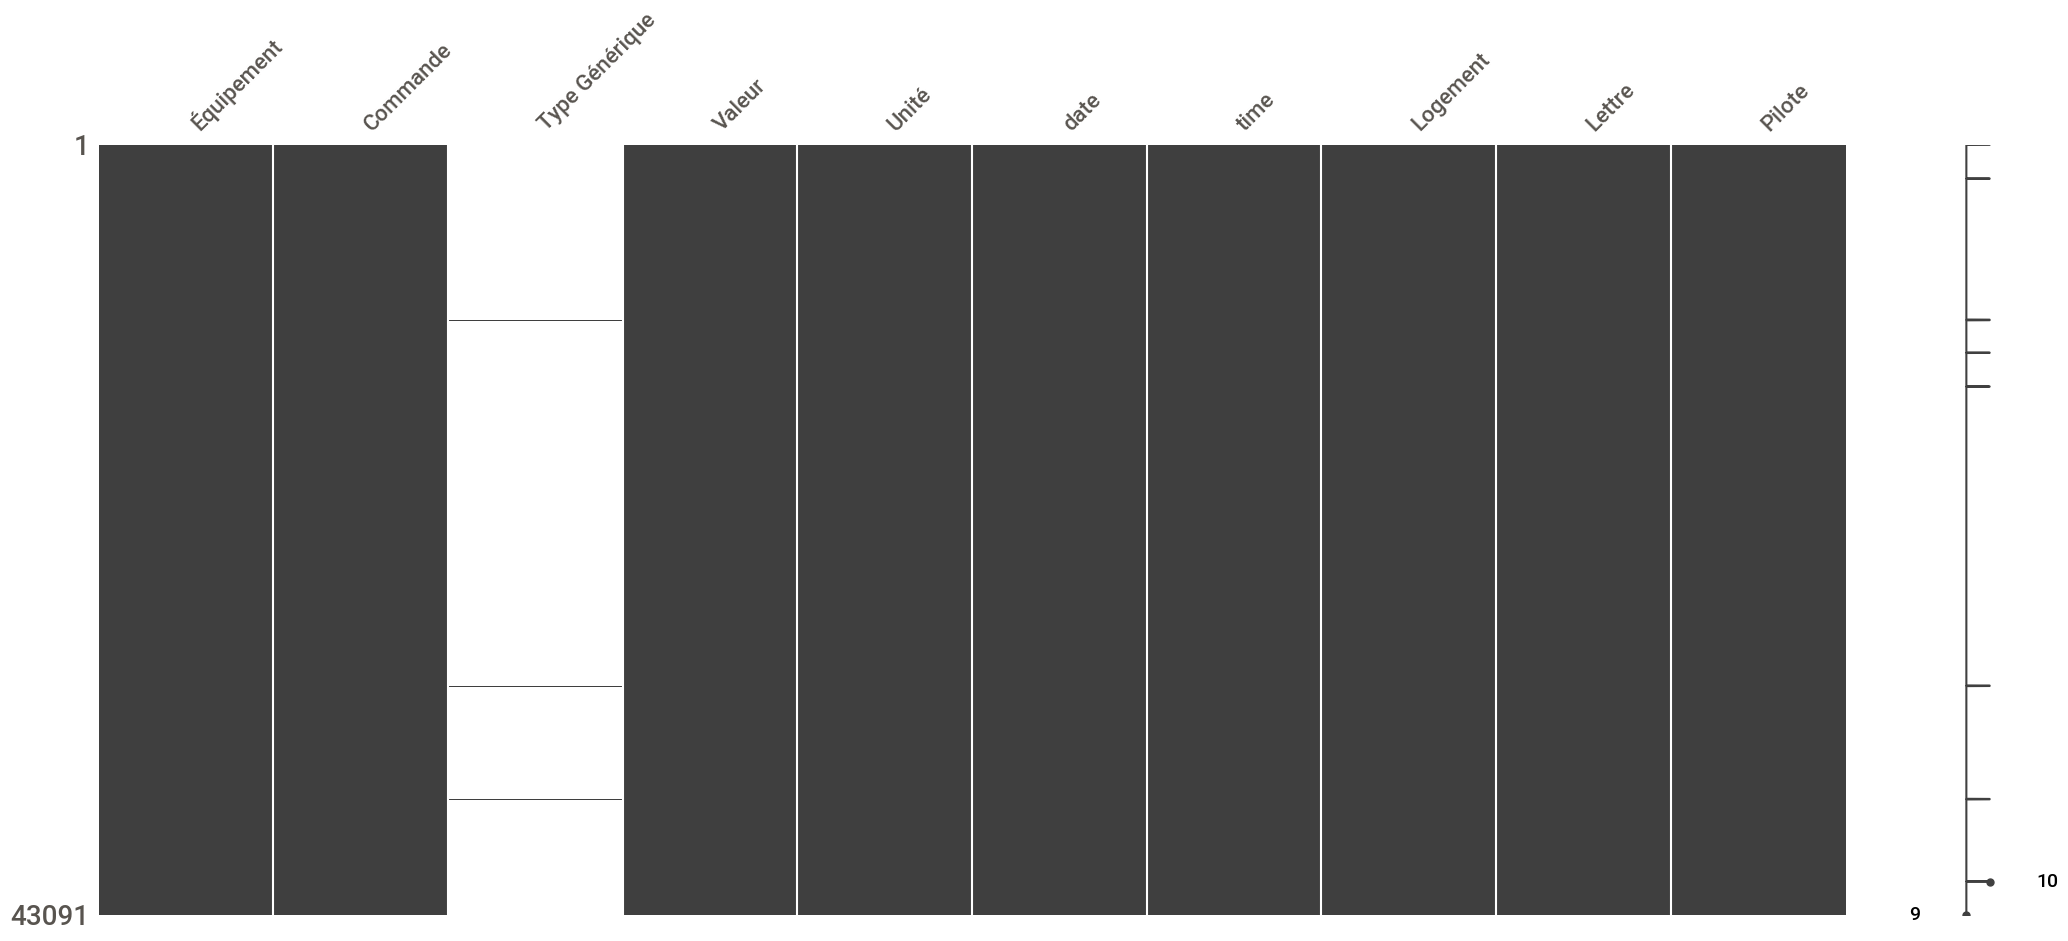

In [107]:
msno.matrix(val_roland)

In [103]:
# Description pour comprendre les données et mettre en suite le tableau en forme
dfSummary(val_roland)

No,Variable,Stats / Values,Freqs / (% of Valid),Graph,Missing
1,Équipement[object],1. Conso_Total_index2. Thermostat3. Conso_horaire4. Chauffage5. Ballon_Eau6. Occupation_Hier7. TV-Frigo8. Occupation_Aujourdhui,"19,261 (44.7%)10,942 (25.4%)7,486 (17.4%)4,992 (11.6%)116 (0.3%)109 (0.3%)98 (0.2%)87 (0.2%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAC4CAYAAAD0WZ4UAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjguMCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy81sbWrAAAACXBIWXMAAA9hAAAPYQGoP6dpAAADA0lEQVR4nO3cQUocUQBF0V/SmGTSjQguIdmDi8his4heRPYgYg2icdIZBDIKUUh7qyjPWcFHLvWppp7T6XQaULhY+gC8H2IjIzYyYiMjNjJiIzONMT6NMS6XPsjKPJ9Op8elD7E1u+vr66/7/f5q6YOsyTzP99M0fRPcee32+/3V7e3t4+FweFr6MGvw8PDw8Xg8Xt3d3V2OMcR2RrsxxjgcDk83Nzc/lj7Minxa+gBb5AWBjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNzG6M35/VLH2QtfC3eDu7eZ7vj8fj1fBZzR/zPN+PMZ6XPsfW+Cz873wW/gYm/36BytqfbJ4wG7LqwYvhybasdvBieLI9ax+8eEPeED/qkhEbGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxkVnt4GWNZ+L/rHrwYniyLT4LJ2PwQsYLApn6GnUtvmPpuspa6n3L1lXWUtTrqtX9vELHCwIZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRERuZbF1lLUW6rrKWet98Fk7GuorMOZ9snlr809kGL8YsvOQsgxdjFl7jnIMXYxb+yY+6ZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERkZsZM4yeDFm4TXONngxZuElPgsnY/BCxgsCGbGRuZim6cs0Td4meXMXY4zPY4wPSx+E7XONkhEbGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRuRhjfB9j/Fz6IGyfwQsZ1ygZsZExeCFj8ELGNUpGbGTERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERkZsZKyryFhXkXGNkhEbGesqMtZVZFyjZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkDF7IGLyQcY2SERsZgxcyBi9kXKNkxEZGbGTERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERsa6iox1FRnXKBmxkREbGbGRERsZsZH5Bb057jWeTR8NAAAAAElFTkSuQmCC"">",0(0.0%)
2,Commande[object],1. TIC_enedis2. TemperatureReelle3. Conso_Total_kw/h4. Chauffage_Conso5. Chauffage_Conso_Total6. Chauffage_OnOff7. Presence_absence8. Ballon_OnOff9. TV-Frigo_OnOff10. TemperatureDesiree,"19,261 (44.7%)10,872 (25.2%)7,486 (17.4%)1,936 (4.5%)1,629 (3.8%)1,427 (3.3%)196 (0.5%)116 (0.3%)98 (0.2%)70 (0.2%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAADnCAYAAAAJgSQ2AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjguMCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy81sbWrAAAACXBIWXMAAA9hAAAPYQGoP6dpAAAD00lEQVR4nO3dwW3bZgCG4Z+GkDYXCYYAj9Du4CEybIfQEN3BMKxDk+aiHpL2Ess5lHxJyM8zwQ/jBWkS/OzpcrkMKNytfQDeD7GRERsZsZERGxmxkREbGbGRERuZaYzxcYzxYe2DbMzXy+Xyee1D3Jrd8Xj8tN/v79c+yJacz+fnaZr+ENy8dvv9/v7x8fHz4XD4svZhtuDl5eXX0+l0//T09GGMIbYZ7cYY43A4fHl4ePhr7cNsyMe1D3CLPCCQERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGR2Y3x7bOatQ+yFX4Wy9mdz+fn0+l0P3xW85/z+fw8xvi69jlujc/CX+ez8AVM/ooRla1f2VxhbsimBy+GJ7dls4MXw5Pbs/XBiyfkG+KlLhmxkREbGbGRERsZsZERGxmxkREbGbGRERsZsZERG5nNDl62eCb+n00PXgxPbovPwskYvJCpr2yuVO9YOngxYHnfssGLAQv14GVzT7x0vNQlIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYy2brKWop0XWUt9b7ZIJCxriLzsyubKxGzeXNdZQ3FnK6uq6yhmNvP1lXWUMzGS10yYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyVwcvBirM7c3Bi4EKc/JZOBmDFzJvXdlc1ZjV1cGLsQtze3XwYuzCEt4avBi7MCsvdcmIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2Mi8OngxdmEJVwcvxi7MzWfhZAxeyHhAIHPtNuoWyuxeXVdZVrGEH9ZVllUs5dq6yrKK2XlAICM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiI/PDusqyiqW8uq6yrGIJPgsnY11F5t8r23AlY2m74/H4aYwxDFxY2t1+v7//vq669m8gYRbes5ERGxmxkREbGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxkdl9H7eMYeDCwnwWTsbghYzf2ciIjczdNE2/T9PkTy6wuLsxxm9jjF/WPgi3z22UjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI3M3RjjzzHG32sfhNtn8ELGbZSM2MgYvJAxeCHjNkpGbGTERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERsbghYzBCxm3UTJiI2PwQsbghYzbKBmxkREbGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRsa4iY11Fxm2UjNjIiI2M2MiIjYzYyIiNjNjI/ANCMmlWN6g2QAAAAABJRU5ErkJggg=="">",0(0.0%)
3,Type Générique[object],1. nan2. ALARM_STATE3. THERMOSTAT_SETPOINT,"42,868 (99.5%)153 (0.4%)70 (0.2%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAABFCAYAAABdVZTTAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjguMCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy81sbWrAAAACXBIWXMAAA9hAAAPYQGoP6dpAAABeklEQVR4nO3csW3bUBiF0f8RRBw3JAQCGsHZQUO49Z4ZQkNkCUEsYlsNXdgeQfcB9DmVylt8EEmBT23btoKEofcAfo5WVY9V9av3EHbvNi7L8jxN06H3EvZtXdfLOE3T4XQ6vc7z/NZ7EPt0vV5/n8/nw1hVNc/z2/F4/N97FLv26AGBGLERIzZixEaM2IgRGzFiI0ZsxIiNGLERIzZixEaM2IgRGzFj1ef7Rr2HsF

In [102]:
# Mettre "Chauffage" si les conditions sont remplies
val_roland['Équipement'] = val_roland.apply(
    lambda row: 'Chauffage' if 'Chauffage_OnOff' in row['Commande']
    and row['Équipement'] == '4PM' else row['Équipement'], axis=1)

val_roland['Équipement'] = val_roland.apply(
    lambda row: 'Chauffage' if 'Chauffage_Conso' in row['Commande']
    and row['Équipement'] == '4PM' else row['Équipement'], axis=1)

val_roland['Équipement'] = val_roland.apply(
    lambda row: 'Chauffage' if 'Chauffage_Conso_Total' in row['Commande']
    and row['Équipement'] == '4PM' else row['Équipement'], axis=1)

# Mettre "Ballon_Eau" si les conditions sont remplies
val_roland['Équipement'] = val_roland.apply(
    lambda row: 'Ballon_Eau' if 'Ballon_OnOff' in row['Commande']
    and row['Équipement'] == '4PM' else row['Équipement'], axis=1)

# Mettre "TV-Frigo" si les conditions sont remplies
val_roland['Équipement'] = val_roland.apply(
    lambda row: 'TV-Frigo' if 'TV-Frigo_OnOff' in row['Commande']
    and row['Équipement'] == '4PM' else row['Équipement'], axis=1)


Rapport des données nettoyées :

In [104]:
my_report = sv.analyze(val_roland)

                                             |          | [  0%]   00:00 -> (? left)

In [105]:
my_report.show_html()

Report SWEETVIZ_REPORT.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


Rapport des données de Val Roland, binaire entre les appartements Piloté et les appartements non pilotés.

In [109]:
my_report = sv.compare_intra(val_roland, val_roland["Pilote"] == "non piloté", ["Non piloté", "Piloté"])

                                             |          | [  0%]   00:00 -> (? left)

Report SWEETVIZ_REPORT.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


In [110]:
my_report.show_html()

Report SWEETVIZ_REPORT.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


In [111]:
# Vérifier les types de données pour validation
print(val_roland.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43091 entries, 0 to 43090
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Équipement      43091 non-null  object        
 1   Commande        43091 non-null  object        
 2   Type Générique  223 non-null    object        
 3   Valeur          43091 non-null  object        
 4   Unité           43091 non-null  object        
 5   date            43091 non-null  datetime64[ns]
 6   time            43091 non-null  object        
 7   Logement        43091 non-null  object        
 8   Lettre          43091 non-null  object        
 9   Pilote          43091 non-null  object        
dtypes: datetime64[ns](1), object(9)
memory usage: 3.3+ MB
None


In [58]:
val_roland['Valeur'] = pd.to_numeric(val_roland['Valeur'].str.replace(',', '.'), errors='coerce')